In [8]:
import torch
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import json
import urllib.request
import matplotlib.pyplot as plt
import numpy as np

# Load a pretrained MobileNetV3 model
model = models.mobilenet_v3_large(pretrained=True)
model.eval()
transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
image_path = "german_shepard_dog.jpeg"

In [11]:
def visualize_image(image_tensor):
    image_np = image_tensor.squeeze().permute(1, 2, 0).detach().cpu().numpy()
    plt.imshow(np.clip(image_np, 0, 1))
    plt.axis('off')
    plt.show()
    
# Define a function to print the output image and probabilities
def print_output_image(input_tensor, probabilities):
    plt.imshow(input_tensor.permute(1, 2, 0))  # Permute to show the image in (H, W, C) format
    plt.axis('off')
    plt.show()
    
    # Load ImageNet labels
    with open("imagenet_classes.txt", "r") as f:
        categories = [s.strip() for s in f.readlines()]
    
    # Get top 5 predictions
    top5_prob, top5_catid = torch.topk(probabilities, 5)
    for i in range(top5_prob.size(0)):
        print(categories[top5_catid[i]], top5_prob[i].item())
        
def predict_output_mobilenet_image_path(image_path):
    input_image = Image.open(image_path)
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0)  # create a mini-batch as expected by the model
    
    # Move input and model to GPU if available
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')
    
    with torch.no_grad():
        output = model(input_batch)
    
    # Calculate probabilities
    probabilities = torch.nn.functional.softmax(output[0], dim=0)
    print_output_image(input_tensor, probabilities)

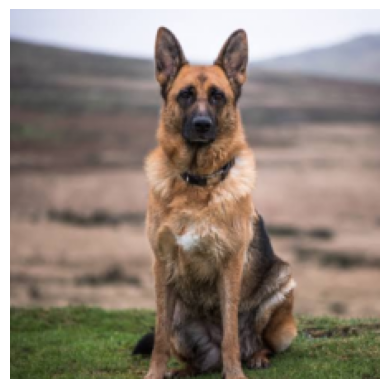

German shepherd 0.9516776204109192
dingo 0.017170807346701622
golden retriever 0.010415079072117805
malinois 0.0044610570184886456
African hunting dog 0.0035482828970998526


In [10]:
predict_output_mobilenet_image_path(image_path)

Step 0, Loss: -3.745107002295356e-11, Predicted label: German shepherd
Step 50, Loss: -3.7928198776127076e-11, Predicted label: German shepherd
Step 100, Loss: -3.8420305131792176e-11, Predicted label: German shepherd
Step 150, Loss: -3.89277256263032e-11, Predicted label: German shepherd
Step 200, Loss: -3.94451415974828e-11, Predicted label: German shepherd
Step 250, Loss: -3.997452369119969e-11, Predicted label: German shepherd
Step 300, Loss: -4.051679131089614e-11, Predicted label: German shepherd
Step 350, Loss: -4.106817663718232e-11, Predicted label: German shepherd
Step 400, Loss: -4.1616481094575164e-11, Predicted label: German shepherd
Step 450, Loss: -4.2172841607790446e-11, Predicted label: German shepherd


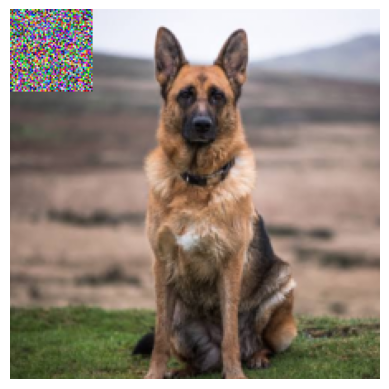

In [12]:
# Adversarial patch training loop
categories = []
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

# Load an example image
def load_image(image_path):
    image = Image.open(image_path).convert("RGB")
    return transform(image).unsqueeze(0)

def apply_patch_direct(image, patch, location):
    patched_image = image.clone()
    h, w = patch.shape[1:3]
    patched_image[:, :, location[0]:location[0]+h, location[1]:location[1]+w] = patch
    return patched_image

def train_patch(image_path, target_class, patch_size=(50, 50), num_steps=500, lr=0.05):
    image = load_image(image_path)
    
    # Initialize random patch with the required size
    patch = torch.rand((3, *patch_size), requires_grad=True)
    optimizer = optim.Adam([patch], lr=lr)

    for step in range(num_steps):
        optimizer.zero_grad()
        
        # Apply patch directly without altering the base image
        patched_image = apply_patch_direct(image, patch, (0, 0))  # Place at the top-left corner
        
        # Forward pass through the model
        output = model(patched_image)
        
        # Apply softmax to get probabilities
        probabilities = F.softmax(output, dim=1)
        
        # Calculate loss to maximize the target class probability
        loss = -probabilities[0][target_class]
        loss.backward()
        
        # Update the patch
        optimizer.step()
        
        # Print training progress every 50 steps
        if step % 50 == 0:
            _, predicted_idx = torch.max(probabilities, 1)
            predicted_label = categories[predicted_idx.item()]
            print(f"Step {step}, Loss: {loss.item()}, Predicted label: {predicted_label}")

    return patch

# Define the target class and train the patch on an example image
target_class = 129  # Replace with your desired target class index (Spoonbill)
image_path = "german_shepard_dog.jpeg"  # Replace with the path to your image 235
trained_patch = train_patch(image_path, target_class, patch_size=(50, 50), num_steps=500, lr=0.05)

# Save the trained adversarial patch
torch.save(trained_patch, "adversarial_patch_direct_mobilenet.pt")

# Load image and apply the adversarial patch for evaluation
image = load_image(image_path)

patched_image = apply_patch_direct(image, trained_patch, (0, 0))  # Place the patch in the same position used during training

# Visualize the patched image
visualize_image(patched_image)

Step 0, Loss: -3.121942981909598e-11, Target Prob: 0.0000, Position: (0, 0), Predicted label: German shepherd
Step 50, Loss: -3.1824657492629527e-11, Target Prob: 0.0000, Position: (0, 0), Predicted label: German shepherd
Step 100, Loss: -3.2451388798371283e-11, Target Prob: 0.0000, Position: (0, 0), Predicted label: German shepherd
Step 150, Loss: -3.3099953333781684e-11, Target Prob: 0.0000, Position: (0, 0), Predicted label: German shepherd
Step 200, Loss: -3.3767256352179587e-11, Target Prob: 0.0000, Position: (0, 0), Predicted label: German shepherd
Step 250, Loss: -3.4451247410416386e-11, Target Prob: 0.0000, Position: (0, 0), Predicted label: German shepherd
Step 300, Loss: -3.5120906183294665e-11, Target Prob: 0.0000, Position: (0, 0), Predicted label: German shepherd
Step 350, Loss: -3.580229862576445e-11, Target Prob: 0.0000, Position: (0, 0), Predicted label: German shepherd
Step 400, Loss: -3.650742555483255e-11, Target Prob: 0.0000, Position: (0, 0), Predicted label: Germa

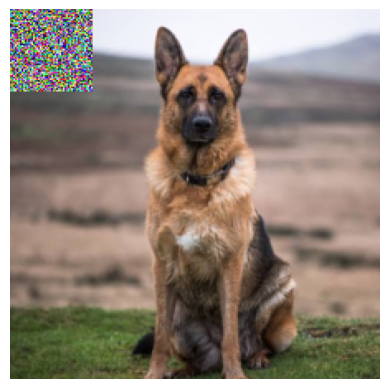

In [23]:
import torch
import torch.optim as optim
import torch.nn.functional as F
from random import randint


def apply_patch_direct_rand(image, patch, position):
    # Ensure image has batch dimension if it doesn't already
    if image.dim() == 3:
        image = image.unsqueeze(0)  # Add batch dimension

    patched_image = image.clone()
    x, y = position
    patch_h, patch_w = patch.shape[1], patch.shape[2]
    
    # Ensure patch has batch and channel dimensions if it doesn't already
    if patch.dim() == 3:
        patch = patch.unsqueeze(0)  # Add batch dimension
    if patch.shape[1] != image.shape[1]:
        patch = patch.expand_as(image[:, :, :patch_h, :patch_w])  # Match channel dimensions

    # Apply the patch at the specified location
    patched_image[:, :, y:y+patch_h, x:x+patch_w] = patch
    return patched_image

def train_patch_max_target_pos(image_path, target_class, patch_size=(50, 50), num_steps=1000, lr=0.10):
    image = load_image(image_path)
    
    patch = torch.rand((3, *patch_size), requires_grad=True)
    optimizer = optim.Adam([patch], lr=lr)
    
    img_h, img_w = image.shape[1], image.shape[2]
    best_position = (0, 0)
    best_probability = 0.0

    for step in range(num_steps):
        optimizer.zero_grad()

        # Search for the position that maximizes the target class probability
        max_probability = 0.0
        current_position = best_position

        for y in range(0, img_h - patch_size[0] + 1):
            for x in range(0, img_w - patch_size[1] + 1):
                position = (x, y)
                patched_image = apply_patch_direct_rand(image, patch, position)

                if patched_image.dim() == 3:
                    patched_image = patched_image.unsqueeze(0)

                output = model(patched_image)
                probabilities = F.softmax(output, dim=1)
                target_prob = probabilities[0][target_class].item()

                # Update if we find a higher target class probability
                if target_prob > max_probability:
                    max_probability = target_prob
                    current_position = position

        # Check if the found position is better than the previous best
        if max_probability > best_probability:
            best_probability = max_probability
            best_position = current_position

        # Apply the patch at the best position found
        patched_image = apply_patch_direct_rand(image, patch, best_position)

        # Forward pass and calculate loss
        if patched_image.dim() == 3:
            patched_image = patched_image.unsqueeze(0)  # Add batch dimension

        output = model(patched_image)
        probabilities = F.softmax(output, dim=1)

        # Calculate loss to maximize the target class probability
        loss = -probabilities[0][target_class]
        loss.backward()

        # Update the patch
        optimizer.step()

        # Print training progress every 50 steps
        if step % 50 == 0:
            _, predicted_idx = torch.max(probabilities, 1)
            predicted_label = categories[predicted_idx.item()]
            print(f"Step {step}, Loss: {loss.item()}, Target Prob: {best_probability:.4f}, Position: {best_position}, Predicted label: {predicted_label}")

    return patch, best_position

# Define the target class and train the patch on an example image
target_class = 129  # Replace with your desired target class index (Spoonbill)
image_path = "german_shepard_dog.jpeg"  # Replace with the path to your image
trained_patch, position = train_patch_max_target_pos(image_path, target_class, patch_size=(50, 50))

# Save the trained adversarial patch
torch.save(trained_patch, "adversarial_patch_direct_mobilenet.pt")

# Load the image for evaluation
image = load_image(image_path)

# Apply the trained patch at the last position used during training
patched_image = apply_patch_direct_rand(image, trained_patch, position)

# Ensure patched_image has batch dimension for visualization if necessary
if patched_image.dim() == 3:
    patched_image = patched_image.unsqueeze(0)

# Visualize the patched image
visualize_image(patched_image.squeeze(0))  # Remove batch dimension for visualization if necessary
